**Submitted By: Danielle Yaffe, Guy Zalsman and Raz Ohayon**

In [78]:
!jupyter nbconvert --to html /content/Assignment4-Final try everrrrrr.ipynb

[NbConvertApp] WARNING | pattern '/content/Assignment4-Final' matched no files
[NbConvertApp] WARNING | pattern 'try' matched no files
[NbConvertApp] WARNING | pattern 'everrrrrr.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_

# **Assignment 4 - Variational Autoencoders**

In this assignment, we will train a model to produce new human faces with variational autoencoders (VAEs). 
Variational autoencoders let us design complex generative models of data, and fit them to large datasets. They can generate images of fictional celebrity faces (as we'll do in this assignment), high-resolution digital artwork and many more tasks. These models also yield state-of-the-art machine learning results in image generation and reinforcement learning. Variational autoencoders (VAEs) were defined in 2013 by Kingma and Wellings [1].

In this assignment, you will build, train and analyze a VAE with the CelebA dataset. You will analyze how well images can be reconstructed from the lower dimensional representations and try to generate images that look similar to the images in the CelebA dataset.

[1] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013). 


# **Section 1: Variational Autoencoders**


Let us recall the structure of the variational autoencoder:

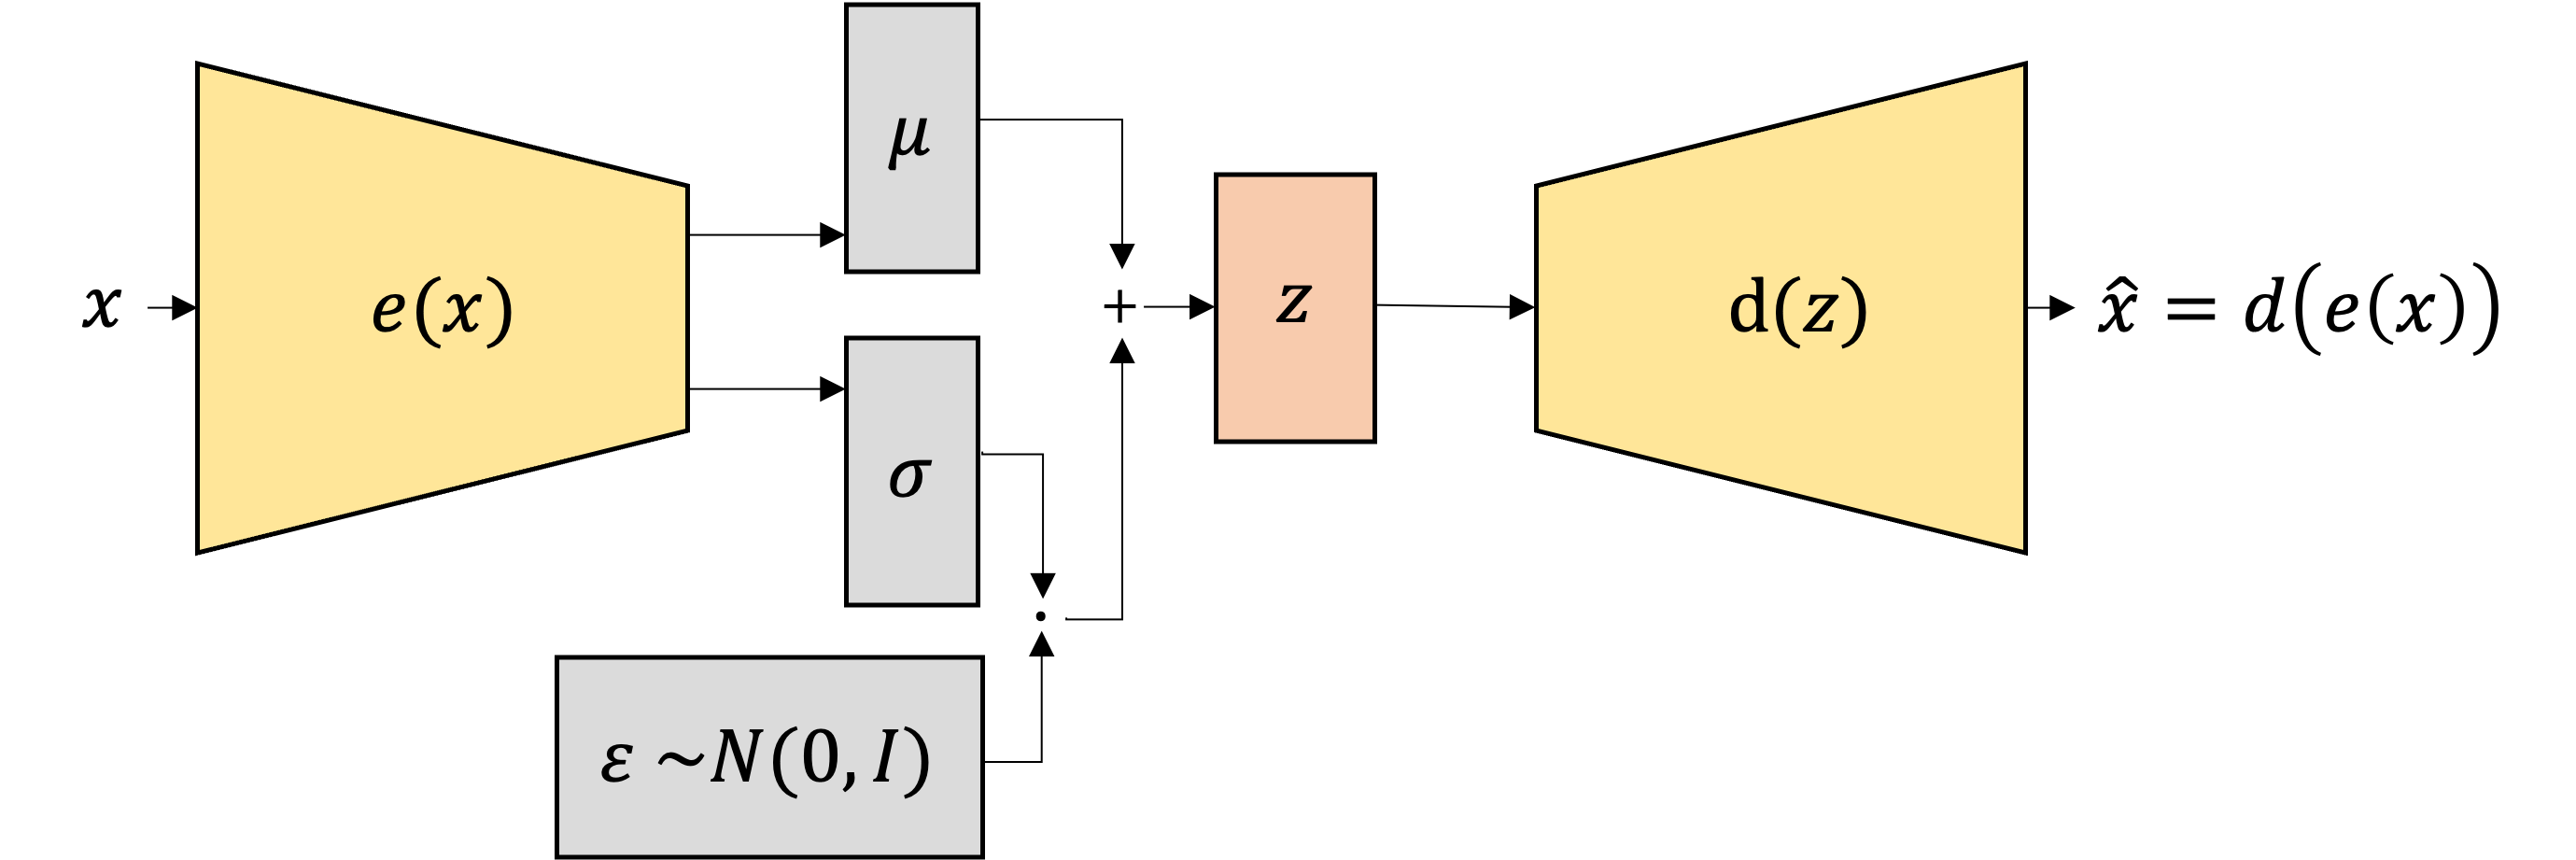

**Imports**

Before we begin, we import the needed libraries. 


You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.

In [5]:
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
from torchvision.io import read_image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as nnF
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import os
import zipfile

%pip install wget   
import wget

# use GPU for computation if possible: Go to RUNTIME -> CHANGE RUNTIME TYPE -> GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=1a9e17aed989c2edd50e16426b572bc3e61fd168406ba379e488106da6201cce
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


Connect to your Google Drive, select the path in your drive for saving the checkpoints of your model, which we will train later.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

# Path to save the dataset.
PATH_TO_SAVE_MODEL = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/VAE' # TODO - UPDATE ME!

Mounted at /content/gdrive


Define random seeds in order to reproduce your results.

In [7]:
# TO DO: Set random seeds - to your choice
torch.manual_seed(100)         # Insert any integer
torch.cuda.manual_seed(100)    # Insert any integer

## Question 1. Basic Principles (10 %)




### Part (a) -- 3%

What is the difference between deterministic autoencoder we saw in class and the variational autoencoder? 

In [8]:
# Write your explanation here

#The difference is that in variational autoencoder we are learning the mean and variance of the distribution of the data and preoducing a latent vector based on
# a normal distribution with those paramteres. While training the model tries to minimize the difference between the original data and the data generated by the
# decoder network, as well as the difference between the true data distribution and the estimated data distribution. After training is complete we can generate
# new data from the same distribution of the training data making the encoder irrelevant. Consequently we are taining a model just for the sake of training a 
#different model. 
#In deterministic autoencoder we use both the encoder and decoder and they work together. We are able only to reconstruct an output from existing data.The model
#is trained to minimize the difference between the original data and the data generated by the decoder network

### Part (b) -- 3%
In which manner Variational Autoencoder is trained? Explain.


In [9]:
# Write your explanation here
#Variational Autoencoder is trained using unsupervised learning. For a set of data with no labels we train our
#model to be able to take an input x_i into the encoder and output the same x_i from the decoder with the restriction
# that the mapping is not the identical mapping. We can do this in many methods discussed such as reducing
# dimentionality. The purpose of the encoder here is to help us learn the disrtibution of the input so later on we
# can generate data from the same distribution and output a relevant result from the decoder. As mentioned before
# the VAE model tries to minimize the difference between the true data distribution and the estimated data
# distribution.
#For example we take celebrity images, learn there distribtution, and later generate new sample that are not
# part of the input data given but are part of the input's distribution space so at the output of the decoder 
#we will reconstruct a fake celebrity that looks completely real!


### Part (c) -- 4%

In class we saw another generative model, known as generative adversarial network (GAN). What are the differences in terms of task objective between GANs and VAEs? Give an example for a task which a VAE is more suitable than GAN, and vice versa.

In [10]:
# Write your explanation here
#With VAE we discussed the difficulties in calculateing the loss function and the many assumption we need to make,
# concluding that this might not be the best way to evalute if a fake image generated by the modal can "pass" as
# a real image. In GAN architecture we were introduced to another componenet called discriminator. The discriminator
# is a supervised learning model which is trained to recognize if an image is fake or real. So know with the
# discriminator we can evalute the output ofour autoencoder - if the autoencoder can fool the discriminator we
# have reached our goal! In this lies the main difference in terms of task abjective, The VAE tries to minimize 
#the difference between the output distrubution and the input distribution while the GAN tries 

#The main objective of a GAN is to generate new, previously unseen examples that are similar to a given dataset. 
#GANs consist of two main components: a generator network and a discriminator network. The generator network is 
#trained to generate new examples, while the discriminator network is trained to distinguish between real examples 
#from the given dataset and fake examples generated by the generator. The two networks are trained in an adversarial
# manner, with the generator trying to produce examples that can fool the discriminator, and the discriminator trying
# to correctly identify the fake examples.

## Question 2. Data (15 %)

In this assignement we are using the CelebFaces Attributes Dataset (CelebA).

The CelebA dataset, as its name suggests, is comprised of celebrity faces. The images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong.

**Overall**

- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

In this torchvision version of the dataset, each image is in the shape of
$[218,178,3]$ and the values are in $[0,1]$.

Here, you will download the dataset to the Google Colab disk. It is highly recommended not to download the dataset to your own Google Drive account since it is time consuming.

In [11]:
data_path = "datasets" ## TO DO -- UPDATE ME!
base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_path}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
     ziphandler.extractall(dataset_folder)

### Part (a) -- 5%

Apply transformations:

The data is given as PIL (Python Imageing Library) images. Since we are working with PyTorch, we wish to apply transformations to the data in order to process it properly.

Here you should apply transformations to the data. There are many kinds of transformations which can be found here: https://pytorch.org/vision/stable/transforms.html. Note that transformations can be chained together using Compose method.

Think which transformations can be suitable for this task and apply it in the form of: 

trfm = transforms.Compose([transforms.transform1(),transforms.transform2(),...])

We recommend to consider:
- transforms.ToTensor()
- transforms.Resize()

In [12]:
trfm = transforms.Compose([transforms.ToTensor()]) # You can add additional transformations which you think could be fit to the data.

training_data = datasets.CelebA(root=data_path, split='train', download=False, transform=trfm) #load the dataset (without download it directly) from our root directory on google drive disk. 
test_data = datasets.CelebA(root=data_path, split='test', download=False, transform=trfm)

### Part (b) -- 5%

In order to get in touch with the dataset, and to see what we are dealing with (which is always recommended), we wish to visualize some data samples from the CelebA dataset.

Write a function: show():

INPUT: Python list of length 32 where each element is an image, randomly selected from the training data.

OUTOUT: Showing a 8X4 grid of images.

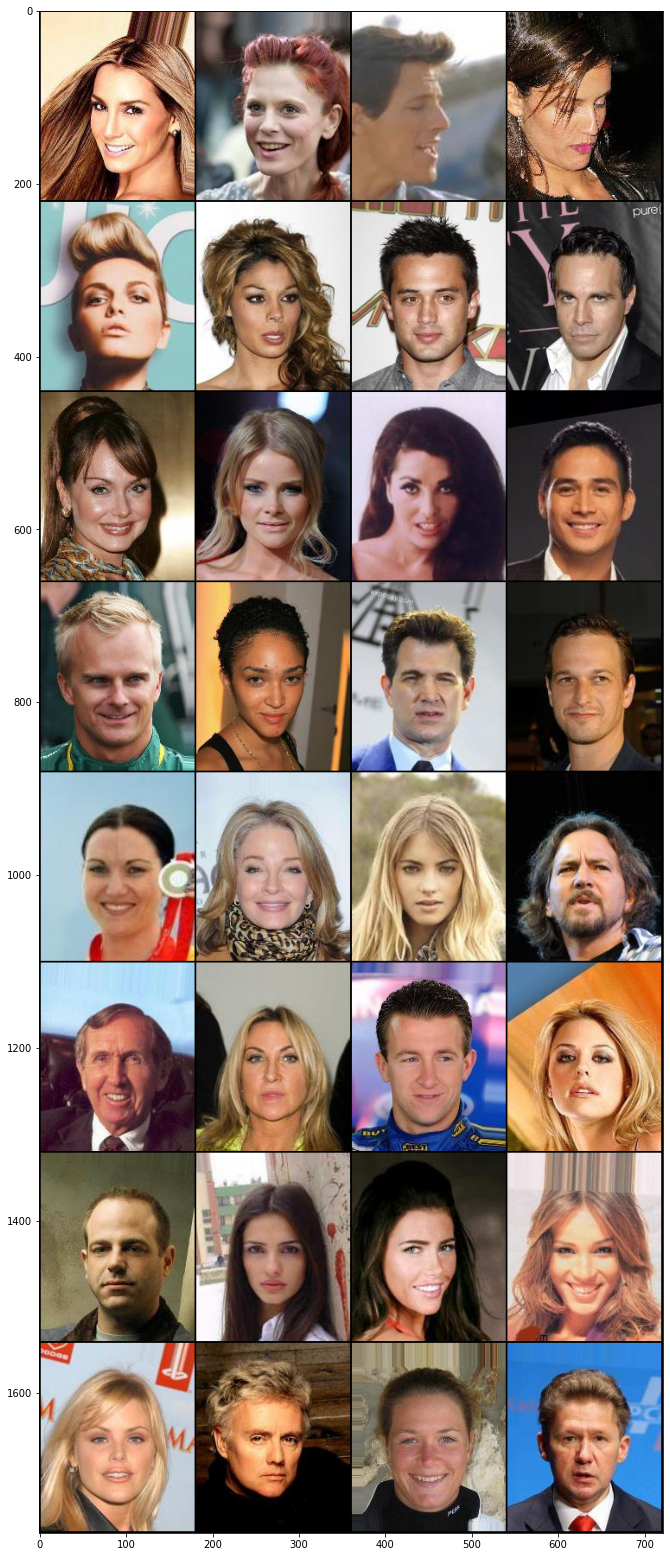

In [13]:
def show(imgs):
    '''
    INPUT: Python list of length 32 where each element is an image, randomly selected from the training data.
    OUTOUT: Showing a 8X4 grid of images.
    '''
    # make grid from the input images
    Grid = make_grid(imgs, nrow=4)
    plt.figure(figsize=(16,28))
    plt.imshow(Grid.permute(1,2,0))

    # display result
    #img = torchvision.transforms.ToPILImage()(Grid)
    #img.show()

    return None

x = []
for i in range(0,32):
  x.append(training_data[i][0])

show(x)

### Part (c) -- 5%

Extrapolate in the image domain:

Here, randomly take 2 images from the training dataset, combine them together and plot the result. For example, consider $X_1$ and $X_2$ to be 2 images randomly taken from the training data. Plot $\alpha\cdot X_1 + (1-\alpha)\cdot X_2$. 

Explain the results, is extrapolation in the image domain reasonable?

Note: Recall that the images should be in the $[0,1]$ interval.

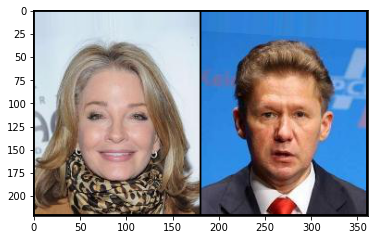

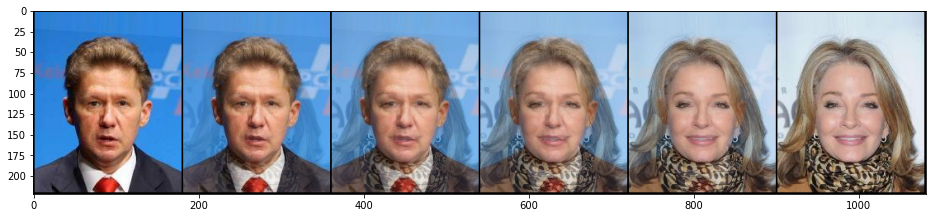

In [14]:
# Your code goes here
rand1 = 17
rand2 = 31
Grid = make_grid([training_data[rand1][0],training_data[rand2][0]], nrow=2)
plt.imshow(Grid.permute(1,2,0))
# display result
img = torchvision.transforms.ToPILImage()(Grid)
img.show()

a=0
transformation = []
while a<1.2:
    combine = ((a)*training_data[rand1][0]+(1-a)*training_data[rand2][0])
    transformation.append(combine)
    a = a+0.2

Grid = make_grid(transformation, nrow=6)
plt.figure(figsize=(16,8))
plt.imshow(Grid.permute(1,2,0))


In [15]:
# Your explanation goes here:
#Here we are taking two images and combining them using the equation α⋅X1+(1−α)⋅X2 where X1 and X2 are the images. 
#The value of α determines the weight given to each image in the combination, for example if α is set to 0, 
#then the resulting image will be a copy of X2, if α is set to 0.5 then the resulting image will be a combination
# of X1 and X2 where each image contibutes exactly the same. We can look at this as a line between two points in 
#space X1 and X2. As we "walk" along the line (=change the value of a) we determine the contibution of each image 
#to the final image. 
#As for whether extrapolation in the image domain is reasonable, it depends on the specific images and context. 
#If the images are very similar, then extrapolation may be reasonable as the combination of the two images may 
#still resemble a meaningful image. However, if the images are very different, then the resulting image may not 
#represent a meaningful image and will not be helpful while training our model.

## Question 3. VAE Foundations (15 %)


Let us start by recalling the analytical derivation of the VAE.


The simplest version of VAE is comprised of an encoder-decoder architecture.
The *encoder* is a neural network which its input is a datapoint $x$, its output is a hidden representation $z$, and it has weights and biases $\theta$. We denote the encoder's mapping by $P_{\theta}(z|x)$. The *decoder* is another neural network which its input is the data sample $z$, its output is the reconstructed input $x$, and its parameters $\phi$. Hence, we denote the decoder's mapping by $P_{\phi}(x|z)$.

The goal is to determine a posterior distribution $P_{\theta}(z|x)$ of a latent variable $z$ given some data evidence $x$. However, determining this posterior distribution is typically computationally intractable, because according to Bayes:

$(1)$ $P(z|x) = \frac{P(x|z)P(z)}{P(x)}$

The term $P(x)$ is called the evidence, and we can calculate it by marginalization on the latent variable:

$P(x) = \int_{z}P(x|z)P(z)dz$

Unfortunately, this term is intractable because it requires computation of the integral over the entire latent space $z$. To bypass this intractability problem we approximate the posterior distribution with some other distribution $q(z|x_i)$. This approximation is made by the KL-divergence:

$(2)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = \int_{z}q(z|x_i)\cdot\log\big(\frac{q(z|x_i)}{P(z|x_i)}\big)dz = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(z|x_i)}{q(z|x_i)}\big)dz \geq 0$

Applying Bayes’ theorem to the above equation yields,

$(3)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)P(x_i)}\big)dz \geq 0$

This can be broken down using laws of logarithms, yielding,

$(4)$ $-\int_{z}q(z|x_i)\cdot\big[\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)-\log(P(x_i))\big]dz \geq 0$

Distributing the integrand then yields,

$(5)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\int_{z}q(z|x_i)\log(P(x_i))dz \geq 0$

In the above, we note that $log(P(x))$ is a constant and can therefore be pulled out of the second integral above, yielding,

$(6)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i))\int_{z}q(z|x_i)dz \geq 0$

And since $q(z|x_i)$ is a probability distribution it integrates to 1 in the above equation, yielding,

$(7)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i)) \geq 0$

Then carrying the integral over to the other side of the inequality, we get,

$(8)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz$

<!-- Applying rules of logarithms, we get,

$(9)$ $\log(P(x)) \geq \int_{z}q(z|x)\cdot\big[\log\big(P(x|z)\big)+\log\big(P(z)\big)-\log\big(q(z|x)\big)\big]dz$

Recognizing the right hand side of the above inequality as Expectation, we write,

$(10)$ $\log(P(x)) \geq E_{~q(z|x)}\big[\log\big(P(x,z)\big)-\log\big(q(z|x)\big)\big]dz$ -->

From Equation $(8)$ it follows that:

$(9)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(z)}{q(z|x_i)}\big)dz + \int_{z}q(z|x_i)\cdot\log\big(P(x_i|z)\big)dz$

Which is equivalent to:

$(10)$ $\log(P(x_i)) \geq -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$



The right hand side of the above equation is the Evidence Lower BOund (ELBO). Its bounds $\log(P(x))$ which is the term we seek to maximize. Therefore, maximizing the ELBO maximizes the log probability of our data. 


### Part (a) -- 5%
 A we see above, the $ELBO = -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$ is comprised of 2 terms. Explain the meaning of each one of them in terms of a loss function.



In [16]:
# Write your explanation here
#The term DKL(qθ(z|y)||pφ(z)) captures the similarity between the learned probabilistic encoder and the desired
# marginal of the latent. If the KL divergence is large, then q(z|xi) is very different from P(z), which means
# that the approximate posterior is making strong assumptions about z.
#The term −Ez∼qθ(z|y){log pφ(y|z)} describes the accuracy of the decoder
#in matching the input distribution. If the expected log-likelihood is high, then the model is able to
# generate data that is similar to xi, which means that the model is a good fit for the data.

### Part (b) -- 10%

 As we saw in class, in traditional variational autoencoder we assume:

$P(z)$ ~ $N(\mu_p,\sigma_{p}^2) = \frac{1}{\sqrt{2\pi\sigma_{p}^2}}\exp\big(-\frac{(z-\mu_p)^2}{2\sigma_{p}^2}\big)$

and

$q(z|x)$ ~ $N(\mu_q,\sigma_{q}^2) = \frac{1}{\sqrt{2\pi\sigma_{q}^2}}\exp\big(-\frac{(z-\mu_q)^2}{2\sigma_{q}^2}\big)$

Assume $\mu_p = 0$ and $\sigma_{p}^2 = 1$. Show that:

$ -D_{KL}\big(q(z|x_i)||P(z)\big) = \frac{1}{2}\big[1+\log(\sigma_{q}^2)-\sigma_{q}^2-\mu_q^2\big]$ 

 

**WRITE YOUR SOLUTIUON HERE**. (You can also upload your solution as an image.)

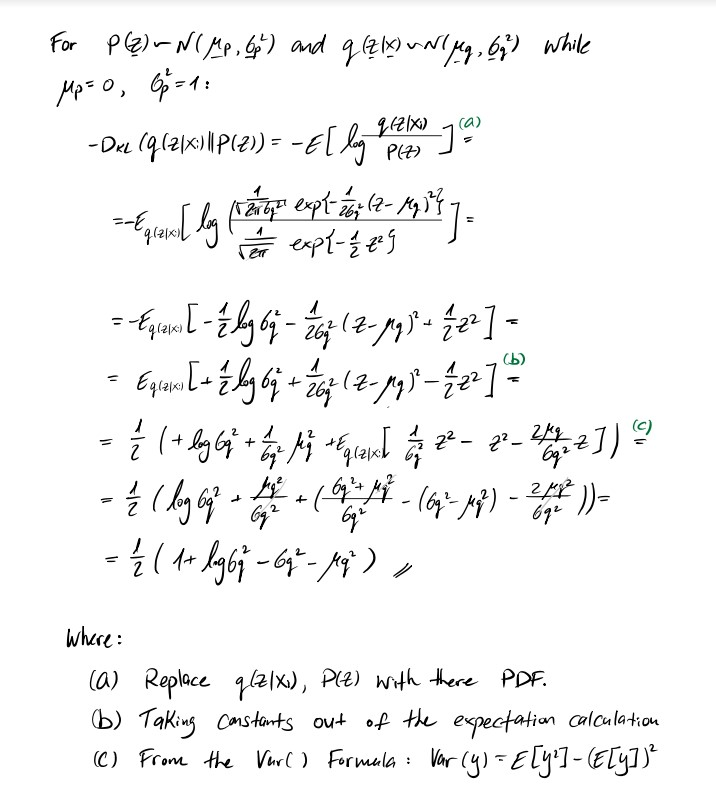



**Minimizing** the loss function, over a batch in the dataset now can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

## Question 4. VAE Implementation (25 %)

As seen in class, a suitable way to extract features from dataset of images is by convolutional neural network (CNN). Hence, here you will build a convolutional VAE.
\
The basic idea is to start from full resolution images, and by convolutional kernels extract the important features of the dataset. Remember that the output of the VAE should be in the same dimensions $(H_1,W_1,C_1)$ as the input images. 

**The encoder** should be comprised of convolutional layers (nn.Conv2d). Recall that the dimension of the input images is changing according to:

$Z = \bigg(H_2(=\frac{H_1-F+2P}{S}+1),W_2(=\frac{W_1-F+2P}{S}+1),C_2\bigg)$

where $S$ is the stride, $F$ is the kernel size, $P$ is the zero padding and $C_2$ is the selected output channels. $Z$ is the output image.

**The decoder** should reconstruct the images from the latent space. In order to enlarge dimensions of images, your network should be comprised of transposed convolutional layers (nn.ConvTranspose2d). See the following images of the operation of transpose convolution to better understand the way it works.




***Transposed Convolution with Stride = 1***

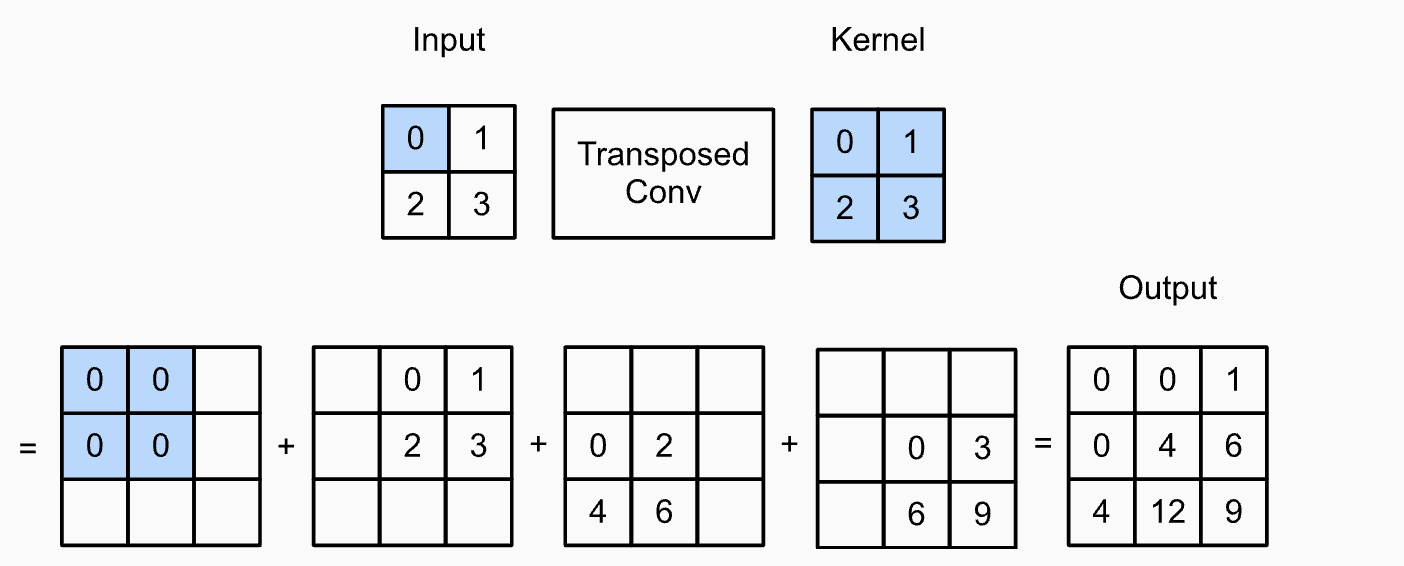

***Transposed Convolution with Stride = 2***
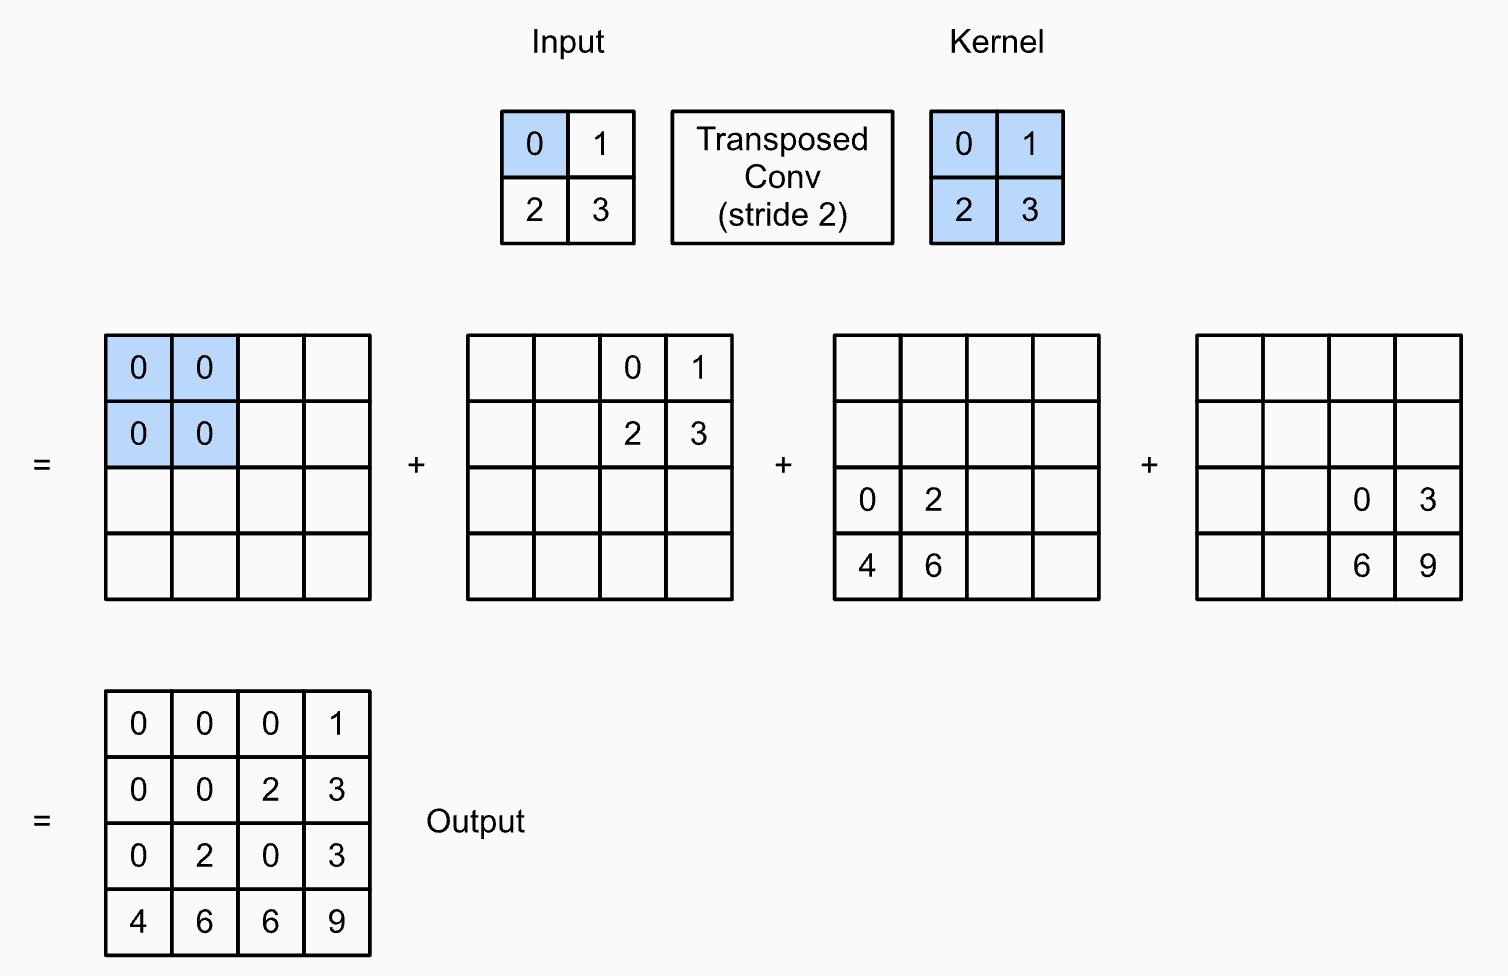

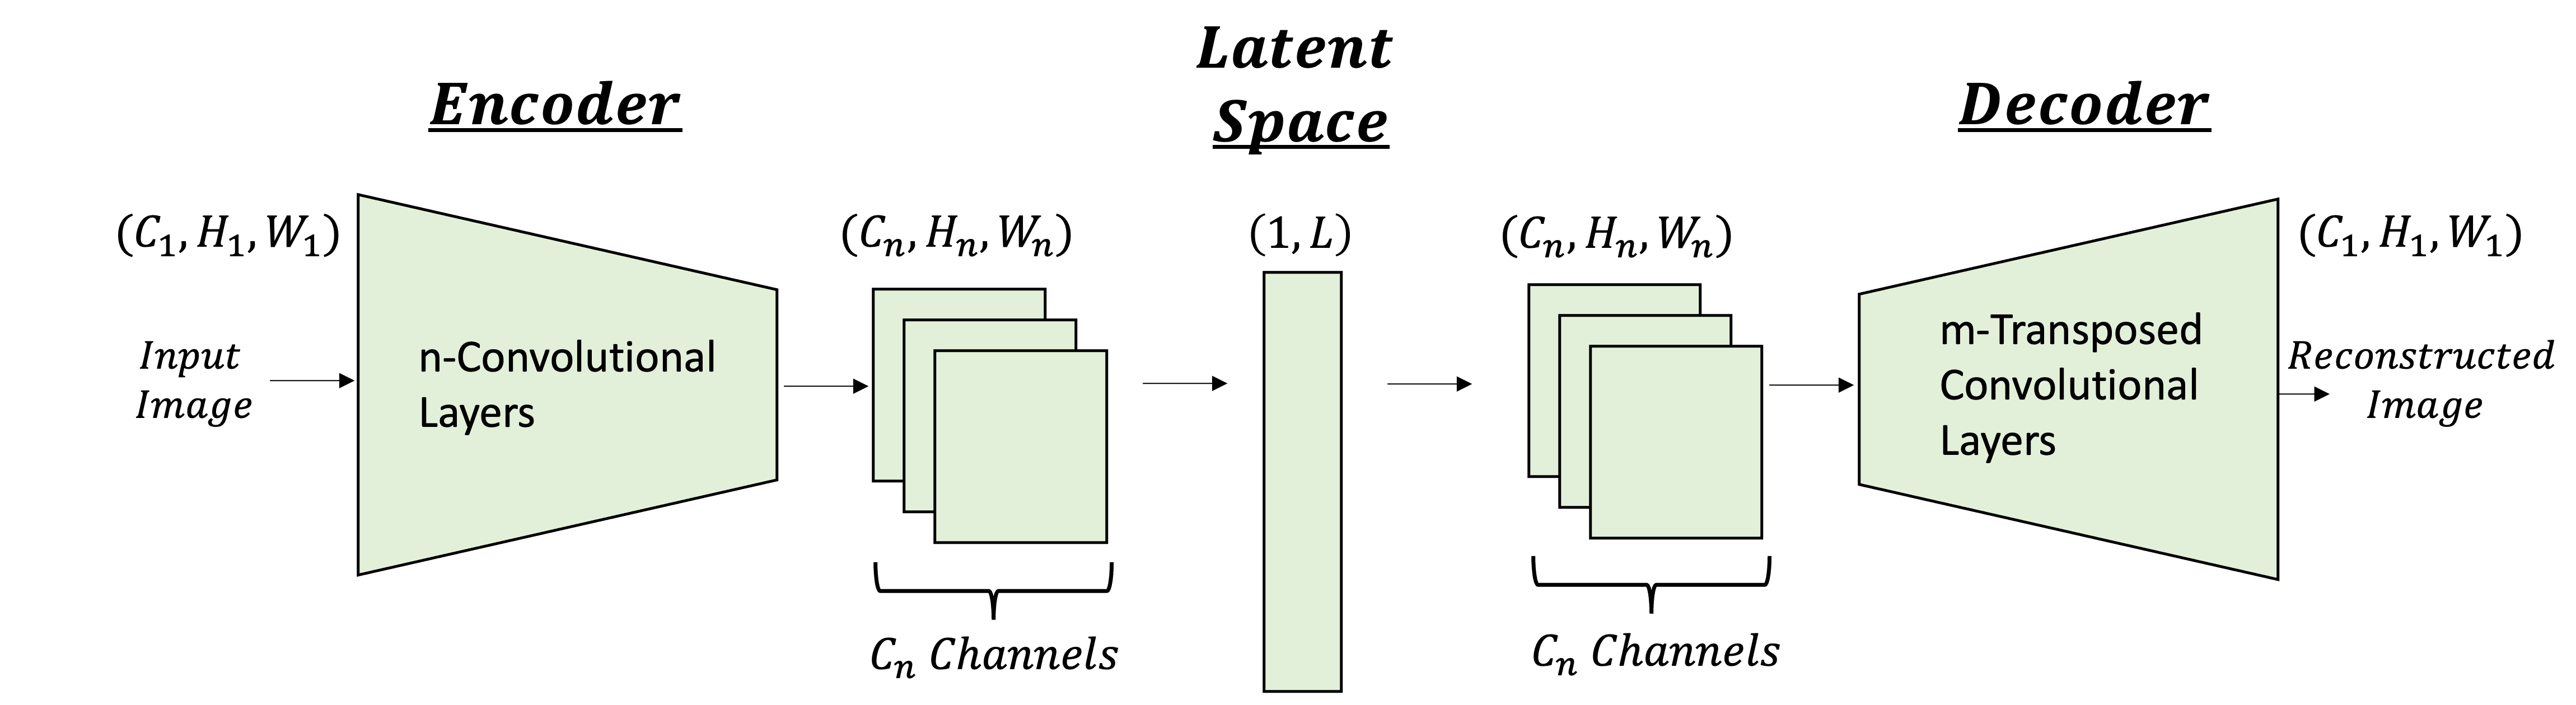

The architecture of your VAE network should be in the following form:


### Part (a) -- 7%

 **Encoder**

Here, you will implement the architecture of the encoder. 

The encoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Convolutional layer (nn.Conv2D(in_channels, num_hidden, kernel_size=(3,3), stride=(2,2)))
- Batch Normalization(num_hidden)
- Activation Function: nn.ReLU()

BLOCK 2: 
- Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 2)
- Activation Function: nn.ReLU()

BLOCK 3: 
- Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 4)
- Activation Function: nn.ReLU()

BLOCK 4: 
- Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 8)
- Activation Function: nn.ReLU()

In addidion to the 4 Blocks, you should add the following linear layers:

Linear $\mu$: 
- nn.Linear( ___ ,latent). 

Linear $\log(\sigma)$: 
- nn.Linear( ___ ,latent).

**NOTES:** 

- The input of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output from the 4'th block to $(H_4\cdot W_4\cdot C_4 , latent)$, where $H_4$ is the height of the output image from the 4'th block, $W_4$ is the width of the output image from the 4'th block and $C_4$ is num_hidden*8 (number of channels of the output image from the 4'th block).

**You can change any parameter of the network to suit your code - this is only a recommendation.**

In [17]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent):
        super(Encoder, self).__init__()
        # YOUR CODE GOES HERE:

        self.num_hiddens = num_hiddens
        self.latent = latent

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
            nn.BatchNorm2d(num_hiddens),
            nn.ReLU()
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(num_hiddens, num_hiddens*2, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
            nn.BatchNorm2d(num_hiddens*2),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(num_hiddens * 2, num_hiddens * 4, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
            nn.BatchNorm2d(num_hiddens*4),
            nn.ReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(num_hiddens * 4, num_hiddens * 8, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(num_hiddens*8),
            nn.ReLU()
        )


        self.fc_mu = nn.Linear(8*num_hiddens*14*12, latent)     # Insert the input size
        self.fc_logvar = nn.Linear(8*num_hiddens*14*12, latent) # Insert the input size

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        #x should be of size: [batch_size, 3, 218, 178]

          inputs = self.block1(inputs)
          inputs = self.block2(inputs)
          inputs = self.block3(inputs)
          inputs = self.block4(inputs)
          inputs = inputs.reshape(-1, 8*self.num_hiddens*14*12)
          
          mu = self.fc_mu(inputs)
          logvar =  self.fc_logvar(inputs)

          return mu, logvar 

**Notice: We output $\log\sigma$ and not $\sigma^2$, this is a convention when training VAEs but it is completely equivalent.**

### Part (b) -- 7%
 **Decoder**

Here, you will implement the architecture of the decoder. 

First, Apply a linear layer to the input of the decoder as follows:

- nn.Linear(latent, ___ ).

The output of the linear layer should match to $H_4\cdot W_4\cdot C_4$, which were the same parameters from the encoder 4'th block's output.

Then, the decoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Transposed Convolutional layer (nn.ConvTranspose2d(in_channels, num_hidden // 2, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 2)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 2: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 2, num_hidden // 4, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 4)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 3: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 4, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 4: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 8, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()


Afterwards, we should generate an image in the same size as our input images. Thus add 1 more block consisting of:

BLOCK 5:
 - nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
 - Activation function.

**NOTES:** 

- The output of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the  transposed convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output of the linear layer to ($Batch, H_4, W_4, C_4$)

- The output of the decoder should be of values in $[0,1]$.



**You can change any parameter of the network to suit your code, this is only a recommendation.**

In [18]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens,latent):
        super(Decoder, self).__init__()
        # YOUR CODE GOES HERE:
        self.num_hiddens = num_hiddens
        self.fc_dec = nn.Linear(latent,num_hiddens*14*12) # Insert the output size

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, num_hiddens // 2, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(num_hiddens // 2),
            nn.LeakyReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=(4,4), stride=(2,2), padding=(2,2)),
            nn.BatchNorm2d(num_hiddens // 4),
            nn.LeakyReLU()
            )

        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 4, num_hiddens // 8,  kernel_size=(4,4), stride=(2,2), padding=(0,2)),
            nn.BatchNorm2d(num_hiddens // 8),
            nn.LeakyReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 8, num_hiddens // 8, kernel_size=(4,4), stride=(2,2),padding=(2,2)),
            nn.BatchNorm2d(num_hiddens // 8),
            nn.LeakyReLU()
        )
        
        self.block5 = nn.Sequential(        # Add convolution layer and activation layer
            nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.Sigmoid()
        ) 

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
          inputs = self.fc_dec(inputs)
          inputs = inputs.view(-1, self.num_hiddens, 14, 12)
          inputs = self.block1(inputs)
          inputs = self.block2(inputs)
          inputs = self.block3(inputs)
          inputs = self.block4(inputs)
          x_rec = self.block5(inputs)
          
          return x_rec

### Part (c) -- 4% 
**VAE Model**

Once you have the architecture of the encoder and the decoder, we want to put them together and train the network end-to-end.

Remember that in VAEs, you need to sample from a gaussian distribution at the input of the decoder. In order to backpropagate through the network, we use the reparametrization trick. The reparametrization trick is saying that sampling from $𝑧∼N(\mu,\sigma)$ is equivalent to sampling $\varepsilon∼N(0,1)$ and setting $𝑧=\mu+\sigma⊙\varepsilon$. Where, epsilon is an input to the network while keeping your sampling operation differentiable.
The reparametrization function is given to you in the VAE class.

Here, you should write the *forward()* function and to combine all the model's settings to a final network.

In [19]:
class VAE(nn.Module):
    def __init__(self, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent):
        super(VAE, self).__init__()
        self.encode = Encoder(in_channels=enc_in_chnl, num_hiddens=enc_num_hidden,latent = latent)
        self.decode = Decoder(in_channels=dec_in_chnl, num_hiddens=dec_num_hidden,latent = latent)

    # Reparametrization Trick
    def reparametrize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)   #sigma = exp(1/2*log(sigma^2))
      eps = torch.randn_like(std)     #mu
      return eps.mul(std).add_(mu)    #z = mu+sigma*epsilon

    # Initialize Weights
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, x):
        # YOUR CODE GOES HERE:
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_rec = self.decode(z)

        return x_rec , mu, logvar

### Part (d) -- 7% 

**Loss Function**

As we saw earlier, the loss function is based on the ELBO; Over a batch in the dataset, it can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

**$\beta$-Variational Autoencoder ($\beta$-VAE)**

As seen in class, the fact that the ELBO is comprised of the sum of two loss terms implies that these can be balanced using an additional hyperparameter $\beta$, i.e.,

$\beta\cdot D_{KL}\big(q(z|x_i)||P(z)\big) - E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$

It is highly recommended to use the $\beta$-loss for increasing performance. 
 


Explain what could be the purpose of the hyperparameter $\beta$ in the loss function? If $\beta = 1$ is same as VAE, What is the effect of $\beta \neq 1$?

In [20]:
# Write your explanation here
#The hyperparameter β in the loss function is used to balance the relative importance of the reconstruction 
#term and the KL divergence term.
#When β = 1, the two terms have equal weight and the beta-VAE is equivalent to the standard VAE. However,
# when β ≠ 1, the KL divrgence term is scaled by β, making it more or less important than the reconstruction term.
# This can be used to trade-off reconstruction quality and disentanglement in the latent space.
#Increasing β will push the model to prioritize the KL divergence term more, which can lead to a more disentangled
# representation of the data at the cost of a lower reconstruction quality, while decreasing β will make the 
#model to prioritize the reconstruction term more, which can lead to a better reconstruction quality but a less 
#disentangled representation of the data.

Here you should write specifically the code for the loss function.


In [21]:
beta = 0.3

def vae_loss(x_recon, x, mu, logvar):
    beta = 0.3

    #criterion = ()  #nn.MSELoss(x_recon, x)
    BCE = nnF.binary_cross_entropy(x_recon, x, reduction='sum')
    # sum over last dim to go from single dim distribution to multi-dim
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).mean(dim=0)
    
    return BCE, KLD*beta

 Here, define all the hyperparameters values for the training process. 

We gave you recommended values for the VAE model. You can modify and change it to suit your code better if needed.

In [22]:
learning_rate = 0.0001
batch_size = 64
num_epochs = 50
dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.

#VAE Class inputs: 
enc_in_chnl = 3
enc_num_hidden = 32
dec_in_chnl = 256
dec_num_hidden = 256

In [23]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 

## Question 5. VAE Training (15 %)



### Part (a) -- 4% 
Complete the training function below

In [24]:
def train(num_epochs,batch_size,dataset_size,model,checkpoint_path=None):
    '''  
    This is a starter code for the training process. You can modify it for your 
    own conveinient.
    num_epochs - number of training epochs
    batch_size - size of the batches
    dataset_size - How many training samples to use. 
    model - The model you are training.   

    Note: decide what are the outputs of the function. 
    '''

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    codes = dict(μ=list(), logσ2=list(), label=list())
    n = 0 # the number of train iterations
    iters_train, train_loss,iters_test, test_loss = [], [], [], []
    
    for epoch in range(num_epochs):   
        #Train 
        model.train()
        t_for_epoch = 0
        for batch_idx, batch in enumerate(train_loader):
            n+=1
            imgs, _ = batch
            if torch.cuda.is_available(): # Returns a bool indicating if CUDA is currently available.
                imgs = imgs.cuda()

            # ===================forward=====================
            imgs_recon, mu, logvar = model(imgs)  
            BCE, KLD = vae_loss(imgs_recon, imgs, mu, logvar) 
            loss_t = KLD+BCE
            t_for_epoch +=(loss_t).item()
            # ===================backward====================
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()

            #30,000 data samples should be enough.    
            if dataset_size // batch_size == batch_idx:
              break

        train_loss.append(t_for_epoch /batch_idx)
        iters_train.append(n)

        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format((epoch+1),batch_idx))

        means, logvars, labels = list(), list(), list()
        with torch.no_grad():
            model.eval()
            v_for_print = 0
            for y, label in test_loader:
                if torch.cuda.is_available(): # Returns a bool indicating if CUDA is currently available.
                    y = y.cuda()
                # ===================forward=====================
                test_recon, mu, logvar = model(y)
                BCE_t, KLD_t = vae_loss(test_recon, y, mu, logvar)
                loss_v = KLD_t+BCE_t
                v_for_print +=(loss_v).item()
                # ===================log========================
                means.append(mu.detach())
                logvars.append(logvar.detach())
                labels.append(label.detach())
        # ===================log========================
        codes['μ'].append(torch.cat(means))
        codes['logσ2'].append(torch.cat(logvars))
        codes['label'].append(torch.cat(labels))
        test_loss.append(v_for_print/len(test_loader))
        iters_test.append(n)
        print(f'====> Train loss for epoch {epoch+1}/{num_epochs}: {t_for_epoch/batch_idx:.4f}   ,Test loss for epoch {epoch+1}/{num_epochs}: {v_for_print/len(test_loader):.4f}')

    return model,iters_train, train_loss,iters_test, test_loss,codes




### Part (b) -- 4%  

We first train with dimension of latent space $L=3$

We recommend to use *weight_init()* function, which helps stabilize the training process. 

In [76]:
latent1 = 3

if torch.cuda.is_available():
    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1).cuda()
    model_1.weight_init(mean=0, std=1)
else:
    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1)
    model_1.weight_init(mean=0, std=1)


Train your model, plot the train and the validation loss graphs. Explain what is seen.

In [2]:
def plot_learning_curve(iters_train, train_loss, iters_test, test_loss):

  plt.plot(iters_train, train_loss, label = "Train")
  plt.plot(iters_test, test_loss, label = "Validation")
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title('Learning Curve: Train Loss per Epoch')
  plt.legend()
  plt.show()
  return


In [78]:
#model_1,iters, train_loss, test_loss = train(num_epochs,batch_size,dataset_size,model_1)
model_1,iters_train, train_loss,iters_test, test_loss,codes = train(num_epochs,batch_size,dataset_size,model_1)

====> Train loss for epoch 1/50: 4416757.5716   ,Test loss for epoch 1/50: 4280606.5569
====> Train loss for epoch 2/50: 4307167.8120   ,Test loss for epoch 2/50: 4273532.2188
====> Train loss for epoch 3/50: 4302996.5454   ,Test loss for epoch 3/50: 4272120.7804
====> Train loss for epoch 4/50: 4300860.3900   ,Test loss for epoch 4/50: 4269298.1098
====> Train loss for epoch 5/50: 4293133.4364   ,Test loss for epoch 5/50: 4267152.2853
====> Train loss for epoch 6/50: 4298887.3424   ,Test loss for epoch 6/50: 4257510.6330
====> Train loss for epoch 7/50: 4293703.4209   ,Test loss for epoch 7/50: 4258834.3870
====> Train loss for epoch 8/50: 4289801.7121   ,Test loss for epoch 8/50: 4258318.7468
====> Train loss for epoch 9/50: 4298317.5780   ,Test loss for epoch 9/50: 4255464.4896
====> Train loss for epoch 10/50: 4289572.9882   ,Test loss for epoch 10/50: 4253733.2380
====> Train loss for epoch 11/50: 4284867.7313   ,Test loss for epoch 11/50: 4263265.4960
====> Train loss for epoch 1

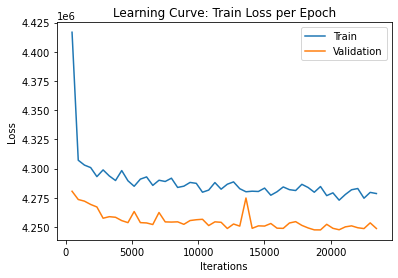

In [79]:
plot_learning_curve(iters_train, train_loss,iters_test, test_loss)

In [80]:
#We can see that our model is learning well at the beginning. The training and validation drop.
# As we continue (around iteration 5000) it seems our model is not able to learn anymore and improve. 
#This can be a result of 
#the hyper parameters but also of the latent space dimension. It is very small and can incapture a limited amount 
#of information. So even as we keep iterating and passing the data through the model it does not help because it
# has learnt what it can.

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Explain.

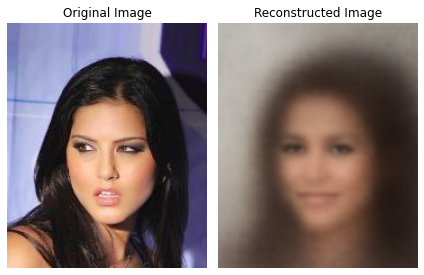

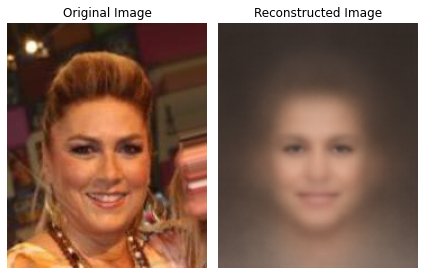

In [86]:
# Your Code Goes Here
model_1.eval()
imgs, _ = next(iter(test_loader))

if torch.cuda.is_available():
    imgs = imgs.cuda()

x_recon, _, _ = model_1(imgs)

imgs = imgs.cpu().numpy()
x_recon = x_recon.detach().cpu().numpy()
# Plot the original image and the reconstructed image
fig, axes =plt.subplots(1,2)
axes[0].imshow(np.transpose(imgs[0], (1,2,0)))
axes[0].axis("off")
axes[0].set_title("Original Image")
axes[1].imshow(np.transpose(x_recon[0], (1,2,0)))
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")
plt.tight_layout()
plt.show()
# Plot the original image and the reconstructed image
fig, axes =plt.subplots(1,2)
axes[0].imshow(np.transpose(imgs[26], (1,2,0)))
axes[0].axis("off")
axes[0].set_title("Original Image")
axes[1].imshow(np.transpose(x_recon[26], (1,2,0)))
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
#**Explanation**
#The model was **not** able to reconstruct the image successfully. This might be for a few reasons regarding the hyper 
#parameters but mainly because of the latent dimension. We trained our model to reduce the input to a latent variable 
#that is 3 dimensional vector meaning we are compressing the information of the input to 3 "main features". Our inputs
#are images composed of many features (!!) so this reduction is too extreme and makes it hard and almost impossible for 
#our model to reconstruct the image properly. We are left with very dominant and general features like face shape,face 
#angle, skin tone and background tone.

In [88]:
torch.save(model_1.state_dict(), '/content/gdrive/MyDrive/Intro_to_Deep_Learning/VAE1/model_param.pk')

### Part (c) -- 7%  

Next, we train with larger $L > 3$

Based on the results for $L = 3$, choose a larger $L$ to improve your results.
Train new model with your choice for $L$.

In [25]:
latent2 = 100 # TO DO: Choose latent space dimension.

if torch.cuda.is_available():
    model_2 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent2).cuda()
    model_2.weight_init(mean=0, std=1)
else:
    model_2 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent2)
    model_2.weight_init(mean=0, std=1)
    
#optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

Plot the train and the validation loss graphs. Explain what is seen.

In [26]:
# Your Code Goes Here
model_2,iters_train2, train_loss2,iters_test2, test_loss2,codes2  = train(num_epochs,batch_size,dataset_size,model_2)

====> Train loss for epoch 1/50: 4006851.8809   ,Test loss for epoch 1/50: 3783286.0986
====> Train loss for epoch 2/50: 3780911.3499   ,Test loss for epoch 2/50: 3735406.8117
====> Train loss for epoch 3/50: 3746235.3248   ,Test loss for epoch 3/50: 3709911.4407
====> Train loss for epoch 4/50: 3734137.4733   ,Test loss for epoch 4/50: 3698475.3702
====> Train loss for epoch 5/50: 3734666.1565   ,Test loss for epoch 5/50: 3700666.9960
====> Train loss for epoch 6/50: 3720872.6405   ,Test loss for epoch 6/50: 3693489.0841
====> Train loss for epoch 7/50: 3722307.6880   ,Test loss for epoch 7/50: 3688712.7396
====> Train loss for epoch 8/50: 3725537.9583   ,Test loss for epoch 8/50: 3690364.0160
====> Train loss for epoch 9/50: 3718749.2222   ,Test loss for epoch 9/50: 3690540.0946
====> Train loss for epoch 10/50: 3717902.1613   ,Test loss for epoch 10/50: 3683241.6907
====> Train loss for epoch 11/50: 3713876.6090   ,Test loss for epoch 11/50: 3684337.4143
====> Train loss for epoch 1

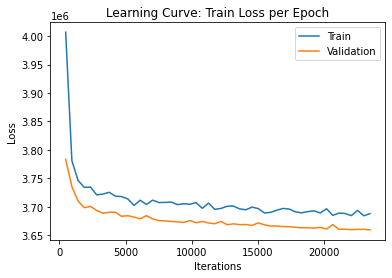

In [27]:
plot_learning_curve(iters_train2, train_loss2,iters_test2, test_loss2)

In [ ]:
#**Explanation:**
#Here we can see our loss is getting smaller and and the model is learning well. The model keeps learning and 
#updated it's paramters to fit best the test, reconstruct the image from the compressed version in the latent space.
#Around iteration 10,000 the loss decreases slower.

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Are the images identical? Explain.

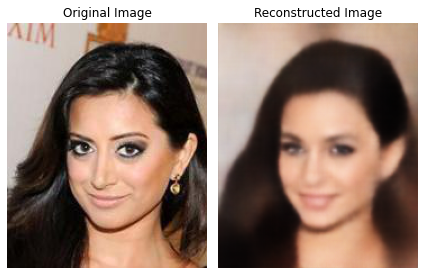

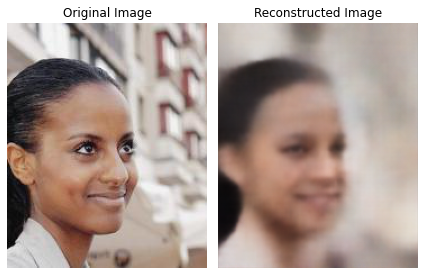

In [28]:
# Your Code Goes Here
model_2.eval()
imgs, _ = next(iter(test_loader))
if torch.cuda.is_available():
    imgs = imgs.cuda()

x_recon, mu, logvar = model_2(imgs)

imgs = imgs.cpu().numpy()
x_recon = x_recon.detach().cpu().numpy()

# Plot the original image and the reconstructed image
fig, axes =plt.subplots(1,2)
axes[0].imshow(np.transpose(imgs[0], (1,2,0)))
axes[0].axis("off")
axes[0].set_title("Original Image")
axes[1].imshow(np.transpose(x_recon[0], (1,2,0)))
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()
# Plot the original image and the reconstructed image
fig, axes =plt.subplots(1,2)
axes[0].imshow(np.transpose(imgs[26], (1,2,0)))
axes[0].axis("off")
axes[0].set_title("Original Image")
axes[1].imshow(np.transpose(x_recon[26], (1,2,0)))
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
#**Explanation:**

#For a larger L we can see a much better reconstruction of the image. The images are not identical but it is clear that
# it is the same image that the model reconstructed. Colors, face features and more are accurate! The model was able to
# learn and reconstruct much more features from the image like hair style, lips, nose, different tone of the face (from makeup)
# and more. This is a significant improvement.

 What will happened if we choose extremely high dimension for the latent space?

In [ ]:
# Write your explanation here
#**Explanation**

#As we saw incresing the dimension of the latent space increses the quality of 
#the reconstruction. We are allowing the model to capture more features in more 
#detil that is needed to reconstruct the image properly. With that said we are 
#risking making the model memorize and fixate leading in to produce similar 
#face for different inputs. To avoid this we can used methods learned in class 
#like dropout and then maybe "enjoy the best of both worlds".

 
Did you output blurry reconstructed images? If the answer is yes, explain what could be the reason. If you got sharp edges and fine details, explain what you did in order to achieve that. 

Note: If you got blurry reconstructed images, just explain why. You dont need to change your code or retrain your model for better results (as long as your results can be interpreted as a human face).
 

In [ ]:
# Write your explanation here
#**Explanation**
#We received blurry images. This is because in the process of the compressing 
#the images. We applied convolution layers and reduced the dimensions of the 
#image resulting in loss of information that later on could not be retrieved. 
#Edges are compressed of the small details in the picture that change rapidly 
#(high frequencies) while the convolution layer operate as a LPF smoothing the 
#images and reducing these edges. We where able to preserve less detailed 
#information like shapes, hair color etc while face textures, hair textures, 
#small details and more where lost. As mentioned before increseing the latent 
#space dimension might have helped and produced less blurry images as we would 
#need to compress less while allowing the model to learn finer details.

## Question 6: Generate New Faces (10 %)

Now, for the fun part!

We are going to generate new celebrity faces with our VAE models. A function for new faces generation is given to you. Modify it (if needed) to fit your code. 



**Model 1 ($L = 3$) results:**

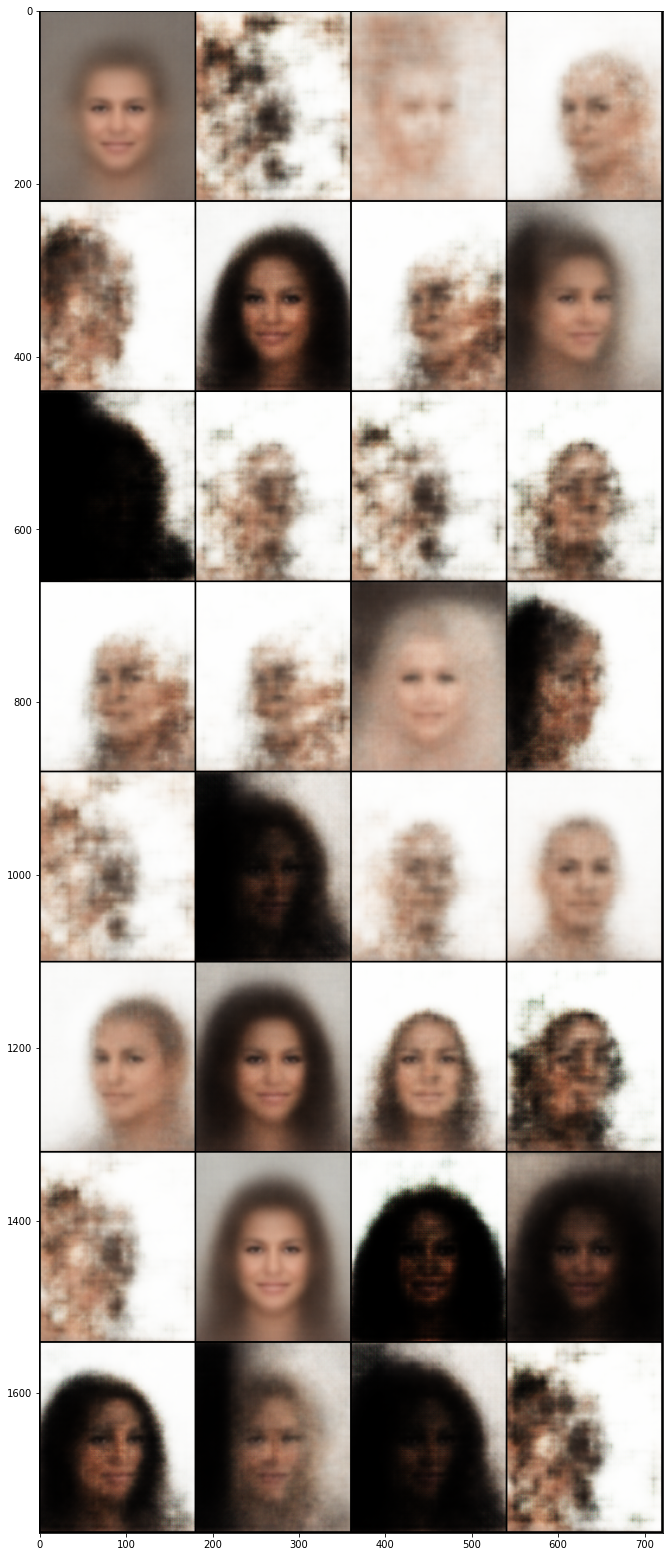

In [89]:
generate_faces(model_1,grid_size=32,latent=latent1)

**Model 2 results:**

In [70]:
# creates random noise sample in the correct shape.
def generate_faces(model, grid_size, latent):
    model.eval()
    dummy = torch.empty([grid_size,latent])
    
    z = torch.randn_like(dummy).to(device)
    
    if latent==3:
      for i in range(grid_size):
          noise=random.randint(5,10)
          z[i]=noise*z[i]+noise/2
    else:
      for i in range(grid_size):
          noise=random.randint(1,2)
          z[i]=z[i]*noise + noise/2
    #insert the random noise to the decoder to create new samples.
    sample = model.decode(z)
    new_face_list = []

    j=0
    while j < grid_size: 
        new_face_list.append(sample[j].cpu().detach())
        j+=1

    #grid = make_grid(new_face_list)
    show(new_face_list)

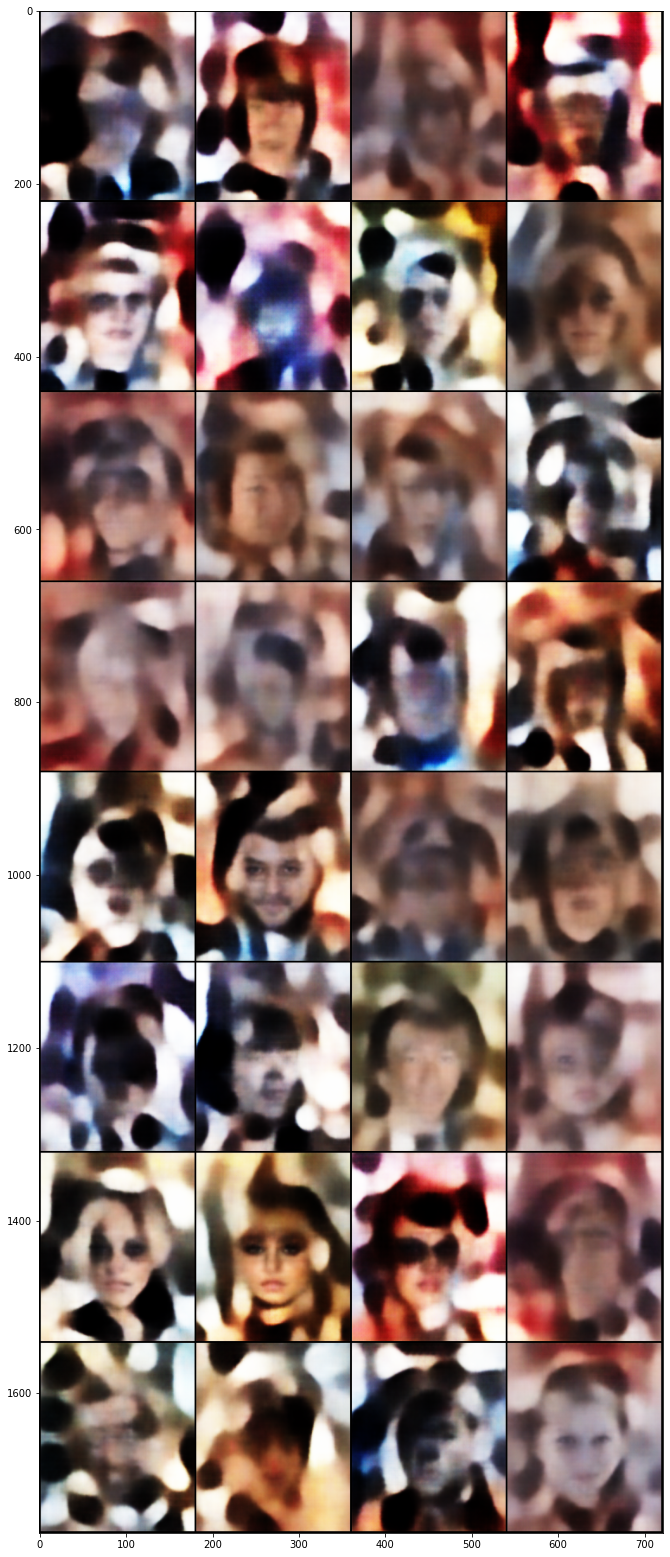

In [71]:
generate_faces(model_2,grid_size=32,latent=latent2)


*Q1:* Generate new faces with VAE model with latent space dimension = 3. Did you get diverse results? What are the most prominent features that the latent space capture? 

*Q2:* Generate new faces with VAE model with your decision for latent space dimension. What are the most prominent features that the latent space capture? 

*Q3:* What are the differences? Your results are similar to the dataset images? Do you get realistic images for your chosen latent space dimension? If not, change your decision or your network to acheive more realistic results.

In [ ]:
#YOUR ANSWERS GOES HERE

# Q1 Answer: Using L=3 we got some interesting results. From the noise generated we where able to receive
# a few images that can look some like people and some that are noise. With that said the images are diverse.
# The diversity lies in the features the model was able to learn with such a small latent: background, face angle
# and skin tone. 

# Q2 Answer: For a larger L the prominent features the latent space captured was the ouline of the face and features
# of the face like noise and lips, and colors. Although the image is noisy we can really see a face!

# Q3 Answer: The main difference between the two models is in the diversity of the people that was generated. For L=3 it
# seems that the model was able to produce one or two people standing from different angles and with a few other changes
# like hair and background. On the other hand from the second model we see different people with different face features.
# Although the images are noisy it does look like images of people. 

## Question 7: Extrapolation (10 %)

Recall that we extrapolate in the images domain in Question 2, part (c).
Here, extrapolate in the latent space domain to generate new images.

Define $\beta = [0, 0.1, 0.2, ... , 0.9, 1]$ and randomly sample from $Z \sim \mathcal{N(0,1)}$ 2 different samples and generate 2 new face images: $X_1, X_2$.

Extrapolate in the latent domain as follows: $\beta_i\cdot Z_1 + (1-\beta_i)\cdot Z_2$ for each $\beta_i \in \beta$.

Plot the extrapolation of the images for each $\beta$ and discuss your results. 
Repeat the process for 3 different samples.



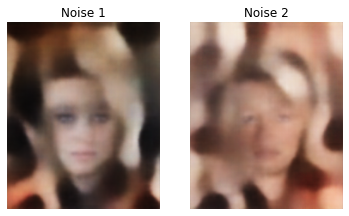

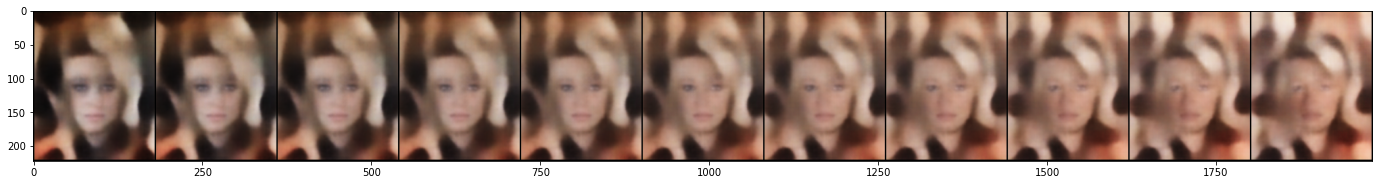

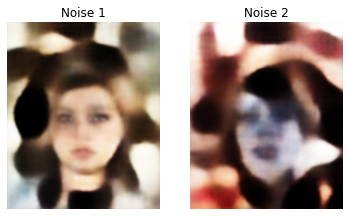

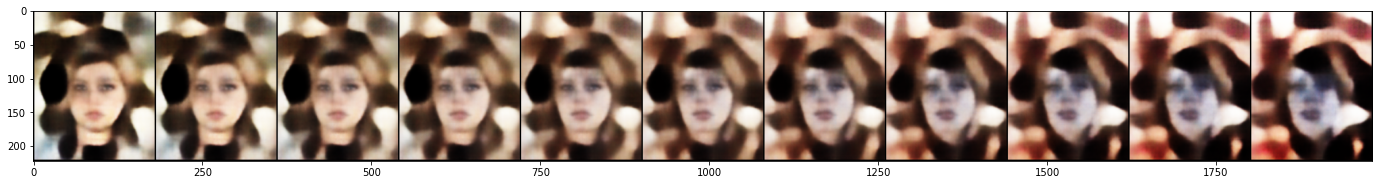

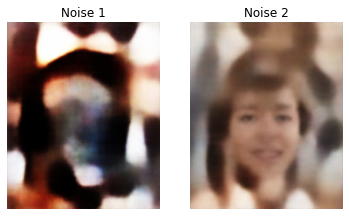

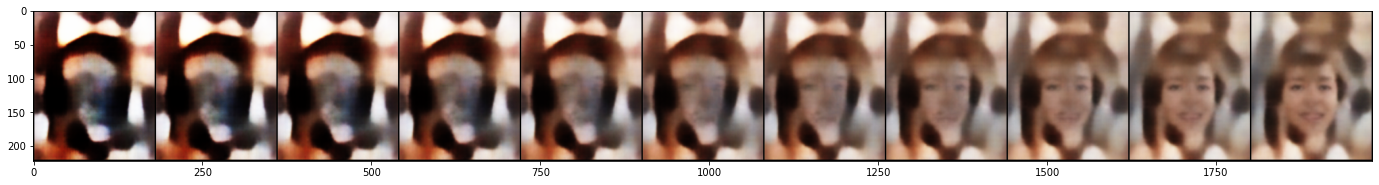

In [77]:
# YOUR CODE GOES HERE
beta_list = [0, 0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

dummy = torch.empty([2,100])

for j in range(3):    
    z = torch.randn_like(dummy).to(device)
    for i in range(2):
          noise=random.randint(1,2)
          z[i]=noise*z[i]+noise/2
          #z[i] = mu[i]+ z[i]*(logvar.exp()[i])

    x_recon = model_2.decode(z).detach().cpu()

    # Plot the original image and the reconstructed image
    fig, axes =plt.subplots(1,2)
    axes[0].imshow(np.transpose(x_recon[0], (1,2,0)))
    axes[0].axis("off")
    axes[0].set_title("Noise 1")
    axes[1].imshow(np.transpose(x_recon[1], (1,2,0)))
    axes[1].set_title("Noise 2")
    axes[1].axis("off")

    x_beta = []
    for b in beta_list:
      #x = z
      #x[0] = b*z[1] + (1-b)*z[0]
      x = b*z[1] + (1-b)*z[0]
      rec_x = model_2.decode(x)
      x_beta.append(rec_x[0].detach().cpu())

    Grid = make_grid(x_beta, nrow=11) 
    plt.figure(figsize=(24,18))
    plt.imshow(Grid.permute(1,2,0))
  

In [ ]:
#**Explanation**
#In contrast to the extrapolation we did earlier, we see here a much better merge between the two images. 
#It no longer looks like two images just pasted one over the other where you can really see each image seperatly.
#We can see the process of shiffting from only one image to the 50,50 combiination and finally to the
# second image. Because we are now doing this in the latent space we are not just adding pixels and creatin
# a nonreal combination, we are now combing both latent vectors and reciving a combination of them feature
# wise. With this we can recounstruct an image of a real person with features combined from both images and
# as a result aquire a realistic merge of the people!
#We also see that for some images when beta was 0.5 or around we received a more realistic person than each
#image alone. Meaning combining the features atributed in created a much better image. 